In [24]:
import pandas as pd
from lxml import html,etree
from requests import get
import pandas as pd
import geopy.distance
import json
import time
import random as rand

In [25]:
headers = ({'User-Agent':
            'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})

Define the main url from imovirtual to gather the properties info

In [26]:
url = 'https://www.imovirtual.com/comprar/apartamento-e-moradia/sintra/?search%5Bfilter_float_price%3Ato%5D=300000&search%5Bfilter_enum_rooms_num%5D%5B0%5D=3&search%5Bfilter_enum_rooms_num%5D%5B1%5D=4&search%5Bfilter_enum_rooms_num%5D%5B2%5D=5&search%5Bfilter_enum_rooms_num%5D%5B3%5D=6&search%5Bfilter_enum_rooms_num%5D%5B4%5D=7&search%5Bsubregion_id%5D=158'

The info from the properties of the previous search will be loaded:
- title
- link to the property
- areas
- house type
- year of construction
- energy certificate
- state of the house
- description
- the minimum distance to one of the locations defined in the list 'locais'

In [34]:
#extract info from imo virtual
title_list, url_list, price_list, size_list, area_list, house_type_list, year_list, certificate_list, state_list, description_list, proximity_list = [],[],[],[],[],[],[],[],[],[],[]

#insert the coordintaes of the locations of interest
location_1 = (38.798525, -9.378356)
location_2 = (38.797805, -9.335724)
locais = [location_1, location_2]

for page in range(0,4):
    page_url = url + '&page=' + str(page)
    r = get(page_url, headers=headers)
    tree = html.fromstring(r.content)
    property_url_list = tree.cssselect('div.offer-item-details h3 a')
    for prop in property_url_list:
        prop_url = prop.get('href')
        r = get(prop_url, headers=headers)
        prop_tree = html.fromstring(r.content)

        # url
        url_list.append(prop_url)

        # Title
        name = prop_tree.cssselect("h1.css-18igut2")[0].text
        title_list.append(name.strip())

        #price css-1vr19r7
        price = prop_tree.cssselect("div.css-1vr19r7")[0].text
        if len(price) != 0:
            price = float(price[:-1].replace(u' ', u'').replace(',', '.'))
        else:
            price = None
        price_list.append(price)

        #Details css-2fnk9o
        size,area,house_type,year,certificate,state = None,None,None,None,None,None
        details = prop_tree.cssselect("div.css-2fnk9o ul li")
        for detail in details:
            if detail.text_content().startswith('Área útil (m²):'):
                size = float(detail.text_content()[15:-2].strip().replace(' ', '').replace(',', '.'))
            elif detail.text_content().startswith('Área bruta (m²): '):
                area = float(detail.text_content()[17:-2].strip().replace(' ', '.').replace(',', '.'))
            elif detail.text_content().startswith('Tipologia: '):
                house_type = detail.text_content()[10:].strip()
            elif detail.text_content().startswith('Ano de construção: '):
                year = float(detail.text_content()[19:].strip())
            elif detail.text_content().startswith('Certificado Energético: '):
                certificate =  detail.text_content()[23:].strip()
            elif detail.text_content().startswith('Condição: '):
                state = detail.text_content()[10:].strip()

        size_list.append(size)
        area_list.append(area)
        house_type_list.append(house_type)
        year_list.append(year)
        certificate_list.append(certificate)
        state_list.append(state)

        #description css-fioe1g
        description = prop_tree.cssselect("section.section-description div p")
        if len(description) > 0:
            description = description[0].text_content()
        else:
            description = ""
        description_list.append(description)

        #coordinates
        if len(prop_tree.cssselect("script[type=\"application/ld+json\"]"))>=3:
            geo = prop_tree.cssselect("script[type=\"application/ld+json\"]")[2].text_content()
            location = json.loads(geo)['@graph'][0]['geo']
            latitude = location['latitude']
            longitude = location['longitude']
            coordinates = (latitude,longitude)
            #proximity
            distances = [geopy.distance.geodesic(coordinates, station).km for station in locais]
            proximity = max(distances)
            proximity_list.append(proximity)
        else:
            proximity_list.append(None)    

    time.sleep(rand.randint(1,2))

In [28]:
#Create Data Frame
cols = ['Title', 'Price', 'Size', 'Area', 'Type', 'Year', 'Certificate', 'State', 'Proximity', 'Description', 'URL']
pd.options.display.float_format = '{: .2f}'.format
df = pd.DataFrame({'Title': title_list,
                           'Price': price_list,
                           'Size': size_list,
                           'Area': area_list,
                           'Type': house_type_list,
                           'Year': year_list,
                           'Certificate': certificate_list,
                           'State': state_list,
                           'Proximity': proximity_list,
                           'Description': description_list,
                           'URL': url_list})[cols]


In [29]:
df.head()

,Title,Price,Size,Area,Type,Year,Certificate,State,Proximity,Description,URL
0,T3 Com Parqueamento -Totalmente Remodelado - B...,189000.00,110.00,nan,T3,nan,C,Renovado,11.67,,https://www.imovirtual.com/anuncio/t3-com-parq...
1,"MASSAMÁ T-3 Rua Francisco Gentil, boas áreas e...",190000.00,125.00,134.00,T3,1988.00,C,Renovado,10.31,"Luis Cardoso, consultor imobiliário Century 21...",https://www.imovirtual.com/anuncio/massama-t-3...
2,T3 Totalmente Remodelado em Mem Martins,195000.00,110.00,120.00,T3,nan,D,Usado,3.93,,https://www.imovirtual.com/anuncio/t3-totalmen...
3,Belas Duplex T3+3 com 210 m2 Qta. Fonteireira,232500.00,150.00,210.00,T5,2002.00,C,Usado,11.18,Comercializado por: BestHouse Mediação Imobili...,https://www.imovirtual.com/anuncio/belas-duple...
4,T3 Massama Norte,235000.00,157.00,nan,T3,nan,C,Usado,9.20,,https://www.imovirtual.com/anuncio/t3-massama-...


In [30]:
df2 = df[(df['Certificate'] != 'F') & (df['Certificate'] != 'E') & (df['Proximity']<5) #& (df['Size']>=250) 
        & (df['State'] != 'Em construção') & (df['State'] != 'Para recuperar')].sort_values('Price')
df2

,Title,Price,Size,Area,Type,Year,Certificate,State,Proximity,Description,URL
43,T3 Remodelado – Tapada das Merces,110000.00,75.00,80.00,T3,1992.00,C,Renovado,3.93,,https://www.imovirtual.com/anuncio/t3-remodela...
59,4 Divisões assoalhadas Mem Martins – Remodelaç...,122500.00,94.00,100.00,T3,1988.00,D,Renovado,2.88,,https://www.imovirtual.com/anuncio/4-divisoes-...
45,T3 Mem-Martins - S. Carlos - Boas áreas,126000.00,100.00,nan,T3,1993.00,D,None,3.06,,https://www.imovirtual.com/anuncio/t3-mem-mart...
62,Apartamento T3 no centro do Linhó,152500.00,95.00,110.00,T3,1987.00,C,Usado,4.05,Comercializado por: West Life Imobiliária,https://www.imovirtual.com/anuncio/apartamento...
56,"Apartamento T3 em Mem Martins, Sintra",159000.00,120.00,125.00,T3,nan,C,Usado,3.93,,https://www.imovirtual.com/anuncio/apartamento...
22,Apartamento T3 em Mem Martins com garagem,165000.00,110.00,135.00,T3,nan,None,Usado,3.93,,https://www.imovirtual.com/anuncio/apartamento...
65,T3 Mem Martins com garagem e arrecadação,175000.00,105.00,125.00,T3,2004.00,D,Renovado,2.53,,https://www.imovirtual.com/anuncio/t3-mem-mart...
2,T3 Totalmente Remodelado em Mem Martins,195000.00,110.00,120.00,T3,nan,D,Usado,3.93,,https://www.imovirtual.com/anuncio/t3-totalmen...
28,Apartamento T3 com 3 varandas e box para 2 carros,199500.00,106.00,122.00,T3,2001.00,C,Usado,3.35,Apartamento com boas áreas na zona de Vale Flo...,https://www.imovirtual.com/anuncio/apartamento...
46,T3 Mem Martins com parqueamento,199500.00,135.00,150.00,T3,1997.00,C,Usado,3.93,,https://www.imovirtual.com/anuncio/t3-mem-mart...


In [31]:
url = df.loc[1]['URL']
chrome_path = 'C:/Program Files (x86)/Google/Chrome/Application/chrome.exe %s'
webbrowser.get(chrome_path).open(url)

True

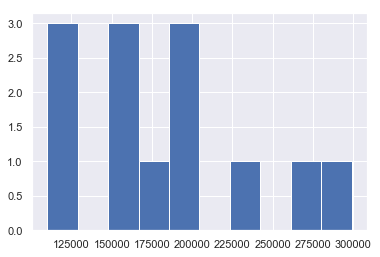

In [32]:
plt.hist(df2['Price'], bins = 10)
plt.show()

In [ ]:
sorry